In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

import sys
sys.path.append("./../../")

from modules.dvae.model import DVAE
from modules.seqGAN.generator.gen_noise import Generator
from modules.seqGAN.discriminator.dis_conv import Discriminator28

from datasets.mnist_loader import MNISTData
from modules.dvae.funcs import ng_quantize

from modules.seqGAN.trainers.train_gen_mle import train_generator_MLE
from modules.seqGAN.trainers.train_gen_pg import one_step_pg_loss
from modules.seqGAN.trainers.train_dis import train_discriminator

from notebooks.utils import show
from modules.seqGAN.funcs import latent_to_img

In [2]:
class Config:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_channels = 1
    vocab_size = 32

    hidden_height = 7
    hidden_width = 7

    num_blocks = 8
    n_attn_heads = 8
    hidden_dim = 256
    dropout_prob = 0.1

    dvae_num_x2upsamples = 2
    dvae_num_resids_downsample = 3
    dvae_num_resids_bottleneck = 4
    dvae_hidden_dim = 256

    mnist_type = "classic"
    root_img_path = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"

    load_dvae_path = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist/"
    dvae_model_name = "dvae_vocab32_mnist"

    model_path = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/seq_GAN_v1/"
    gen_name = "seq_GAN_v1_gen"
    dis_name = "seq_GAN_v1_dis"

    NUM_EPOCHS = 30
    BATCH_SIZE = 128
    LR = 0.001
    LR_gamma = 0.1
    step_LR_milestones = [5, 15, 25]


CONFIG = Config()

In [3]:
def show_example(G, dvae, CONFIG):
    G.eval()

    seq = G.sample(n_samples=64, device=CONFIG.DEVICE)

    latent_x = seq.view(CONFIG.hidden_height, CONFIG.hidden_width, 64, CONFIG.vocab_size).permute(2, 3, 0, 1)
    with torch.no_grad():
        gen_img = dvae.decode(latent_x)

    show(gen_img)

In [4]:
data_source = MNISTData(
    img_type=CONFIG.mnist_type,
    root_path=CONFIG.root_img_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader()

In [5]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim)

dvae.load_model(
    root_path=CONFIG.load_dvae_path,
    model_name=CONFIG.dvae_model_name)

G = Generator(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob)

G_rollout = Generator(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob)

D = Discriminator28(
    in_channels=CONFIG.img_channels,
    hidden_dim=CONFIG.hidden_dim)

dvae.to(CONFIG.DEVICE)
G.to(CONFIG.DEVICE)
G_rollout.to(CONFIG.DEVICE)
D.to(CONFIG.DEVICE)

optimizer_G = optim.Adam(G.parameters(), lr=CONFIG.LR)
optimizer_D = optim.Adam(D.parameters(), lr=CONFIG.LR)

In [6]:
# G = train_generator_MLE(
#     generator=G,
#     optimizer=optimizer_G,
#     train_loader=train_loader,
#     dvae=dvae,
#     num_epochs=30,
#     device=CONFIG.DEVICE,
#     verbose=True,
#     print_iter=50)

# G.save_model(CONFIG.model_path, CONFIG.gen_name)

# D = train_discriminator(
#     discriminator=D,
#     generator=G,
#     optimizer_d=optimizer_D,
#     train_loader=train_loader,
#     dvae=dvae,
#     hidden_height=CONFIG.hidden_height,
#     hidden_width=CONFIG.hidden_width,
#     num_epochs=1,
#     device=CONFIG.DEVICE,
#     verbose=True,
#     print_iter=150)

# D.save_model(CONFIG.model_path, CONFIG.dis_name)

In [7]:
G.load_model(CONFIG.model_path, CONFIG.gen_name)

D.load_model(CONFIG.model_path, CONFIG.dis_name)

G_rollout.load_state_dict(G.state_dict())

pass

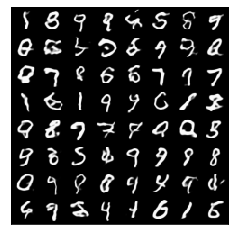

In [8]:
show_example(G, dvae, CONFIG)

Train G
tensor(9.9347, device='cuda:0', grad_fn=<AddBackward0>)


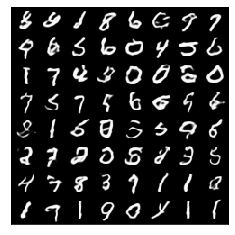

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.00555
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.00027
MLE Dis train: Epoch 0 Iter 450 Loss = 0.00033
Train G
tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


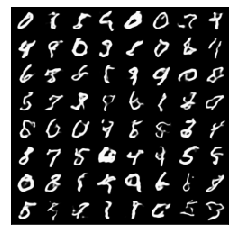

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 1e-05
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0001
MLE Dis train: Epoch 0 Iter 450 Loss = 0.03883
Train G
tensor(3.6880, device='cuda:0', grad_fn=<AddBackward0>)


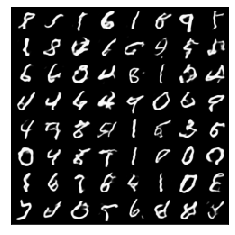

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.00044
MLE Dis train: Epoch 0 Iter 150 Loss = 0.00489
MLE Dis train: Epoch 0 Iter 300 Loss = 1e-05
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


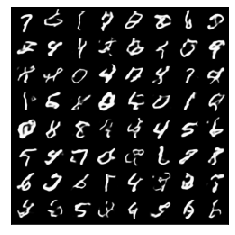

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.1206e-05, device='cuda:0', grad_fn=<AddBackward0>)


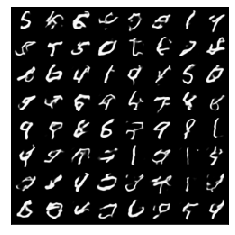

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 3e-05
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


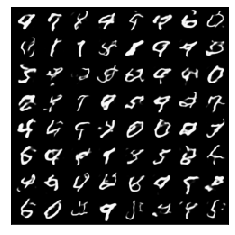

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 4e-05
MLE Dis train: Epoch 0 Iter 150 Loss = 0.00466
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)


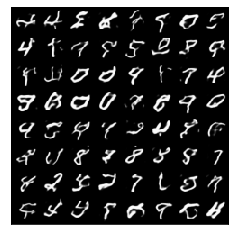

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 1e-05
Train G
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)


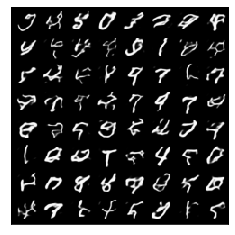

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


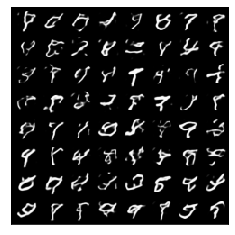

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)


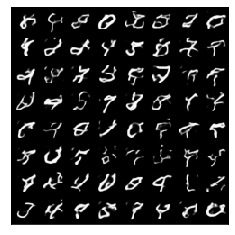

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 1e-05
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(3.1599e-05, device='cuda:0', grad_fn=<AddBackward0>)


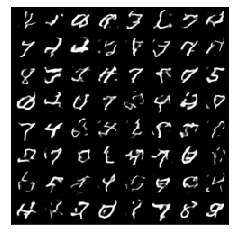

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 2e-05
MLE Dis train: Epoch 0 Iter 300 Loss = 1e-05
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


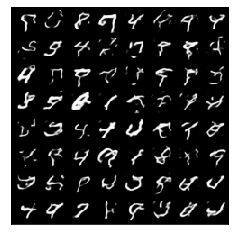

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)


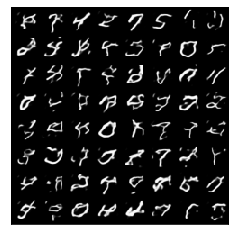

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(4.8244e-05, device='cuda:0', grad_fn=<AddBackward0>)


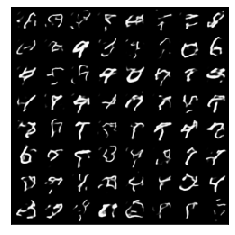

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.2436e-09, device='cuda:0', grad_fn=<AddBackward0>)


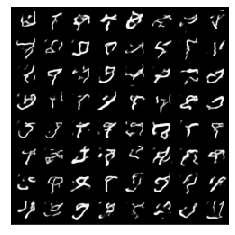

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 1e-05
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.1917e-09, device='cuda:0', grad_fn=<AddBackward0>)


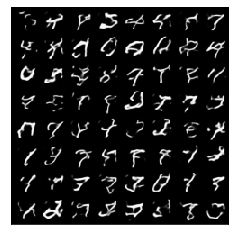

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(5.7770e-07, device='cuda:0', grad_fn=<AddBackward0>)


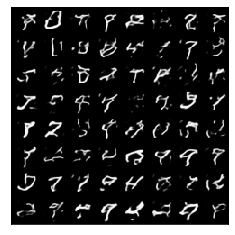

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


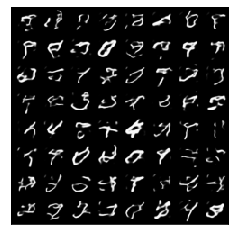

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)


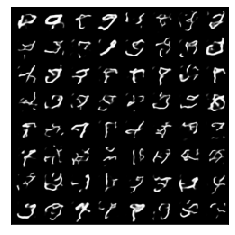

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)


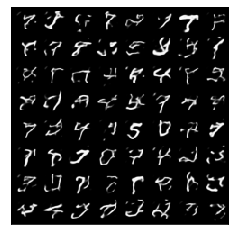

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 1e-05
Train G
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


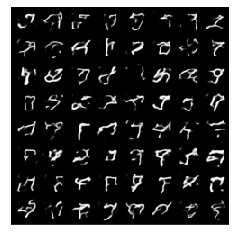

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.0208e-05, device='cuda:0', grad_fn=<AddBackward0>)


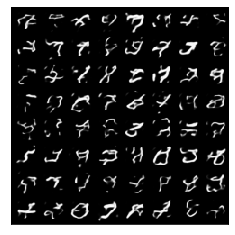

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(5.7073e-07, device='cuda:0', grad_fn=<AddBackward0>)


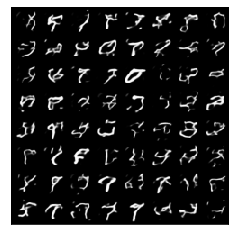

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(9.0023e-09, device='cuda:0', grad_fn=<AddBackward0>)


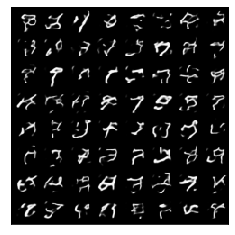

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(3.8457e-10, device='cuda:0', grad_fn=<AddBackward0>)


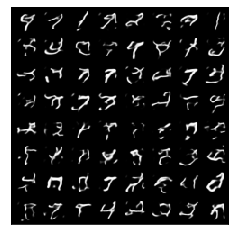

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.5986e-10, device='cuda:0', grad_fn=<AddBackward0>)


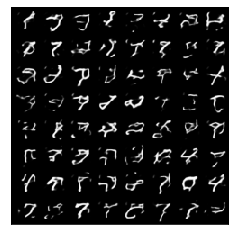

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.4508e-13, device='cuda:0', grad_fn=<AddBackward0>)


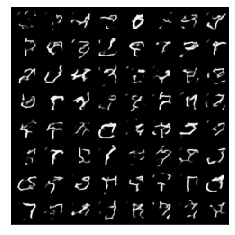

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.00457
Train G
tensor(1.6604e-17, device='cuda:0', grad_fn=<AddBackward0>)


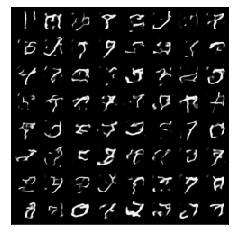

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(8.0836e-06, device='cuda:0', grad_fn=<AddBackward0>)


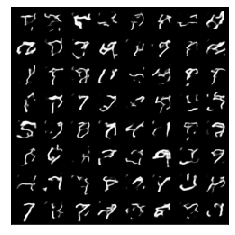

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)


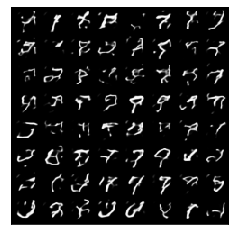

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(4.1299e-07, device='cuda:0', grad_fn=<AddBackward0>)


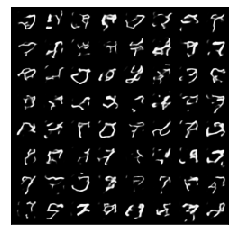

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.6582e-11, device='cuda:0', grad_fn=<AddBackward0>)


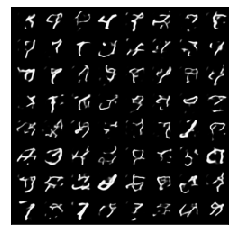

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(7.7163e-07, device='cuda:0', grad_fn=<AddBackward0>)


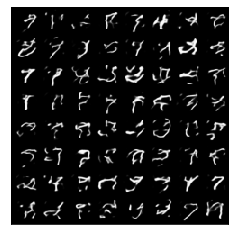

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.2500e-06, device='cuda:0', grad_fn=<AddBackward0>)


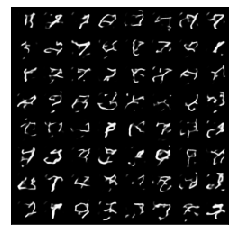

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.7681e-09, device='cuda:0', grad_fn=<AddBackward0>)


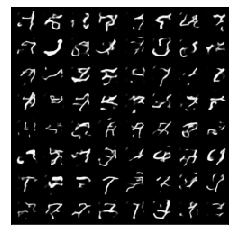

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.5669e-09, device='cuda:0', grad_fn=<AddBackward0>)


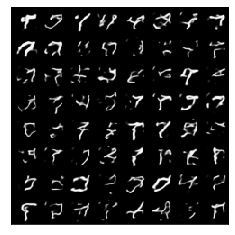

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(4.5523e-12, device='cuda:0', grad_fn=<AddBackward0>)


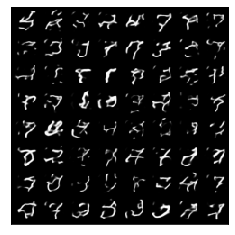

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)


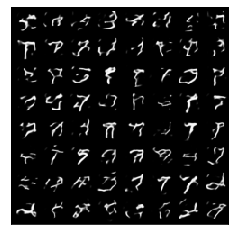

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)


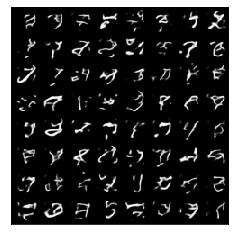

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)


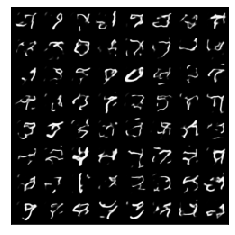

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(4.3990e-05, device='cuda:0', grad_fn=<AddBackward0>)


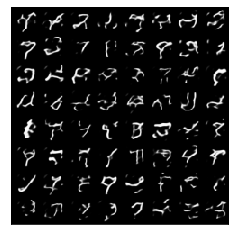

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.6910e-07, device='cuda:0', grad_fn=<AddBackward0>)


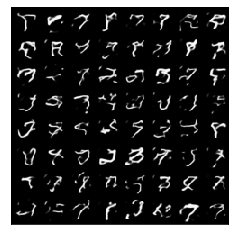

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.6472e-05, device='cuda:0', grad_fn=<AddBackward0>)


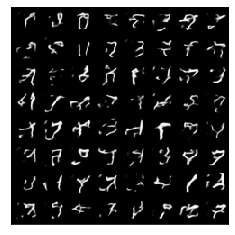

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.3866e-09, device='cuda:0', grad_fn=<AddBackward0>)


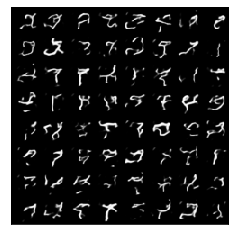

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.5576e-06, device='cuda:0', grad_fn=<AddBackward0>)


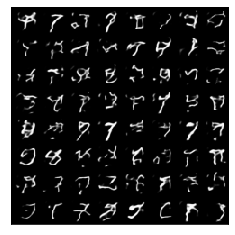

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(3.0757e-12, device='cuda:0', grad_fn=<AddBackward0>)


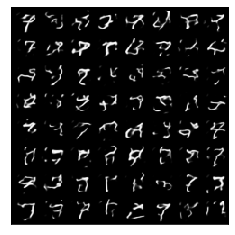

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.0039e-16, device='cuda:0', grad_fn=<AddBackward0>)


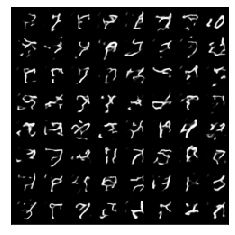

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.00112
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


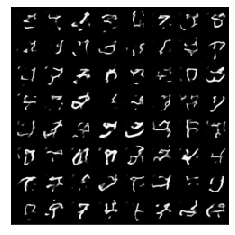

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 1e-05
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.8961e-18, device='cuda:0', grad_fn=<AddBackward0>)


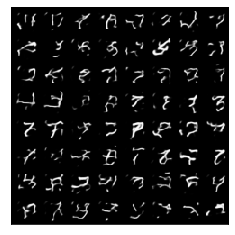

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(8.3465e-13, device='cuda:0', grad_fn=<AddBackward0>)


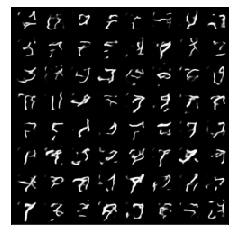

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(3.9379e-16, device='cuda:0', grad_fn=<AddBackward0>)


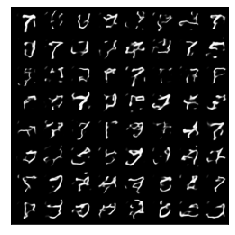

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(8.2100e-15, device='cuda:0', grad_fn=<AddBackward0>)


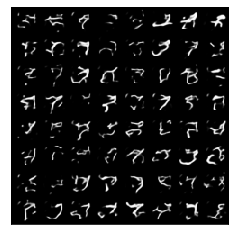

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(9.2427e-19, device='cuda:0', grad_fn=<AddBackward0>)


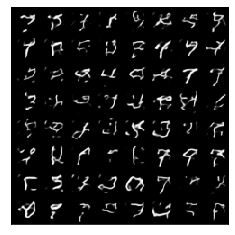

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.4526e-17, device='cuda:0', grad_fn=<AddBackward0>)


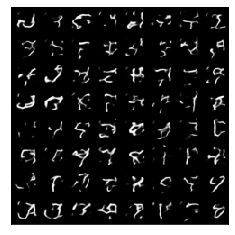

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)


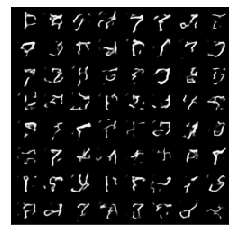

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)


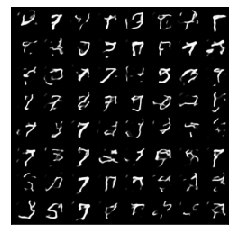

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(8.4496e-12, device='cuda:0', grad_fn=<AddBackward0>)


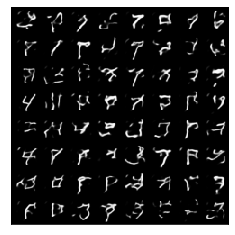

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(3.2883e-05, device='cuda:0', grad_fn=<AddBackward0>)


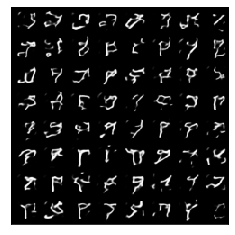

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(5.8910e-09, device='cuda:0', grad_fn=<AddBackward0>)


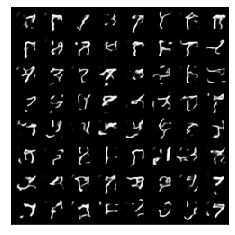

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(6.3758e-13, device='cuda:0', grad_fn=<AddBackward0>)


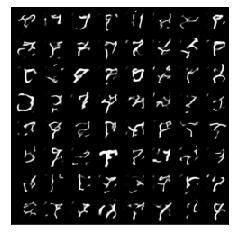

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.2280e-09, device='cuda:0', grad_fn=<AddBackward0>)


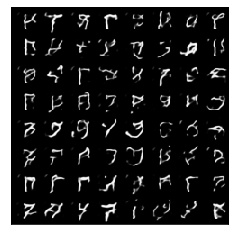

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 1e-05
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.4507e-12, device='cuda:0', grad_fn=<AddBackward0>)


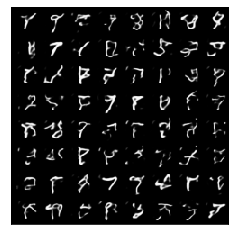

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.4940e-09, device='cuda:0', grad_fn=<AddBackward0>)


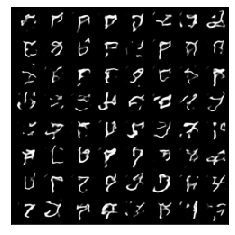

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(3.4814e-23, device='cuda:0', grad_fn=<AddBackward0>)


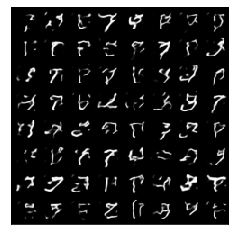

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.4588e-19, device='cuda:0', grad_fn=<AddBackward0>)


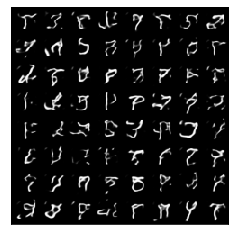

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


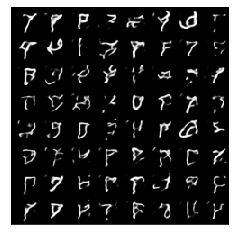

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.3043e-06, device='cuda:0', grad_fn=<AddBackward0>)


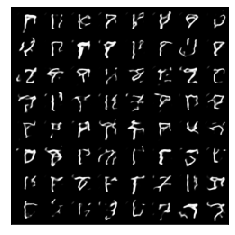

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.1187e-14, device='cuda:0', grad_fn=<AddBackward0>)


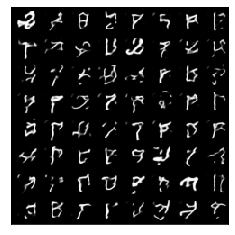

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.02301
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


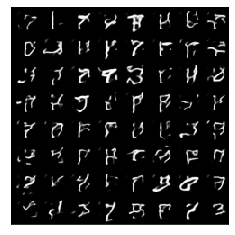

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.1975e-09, device='cuda:0', grad_fn=<AddBackward0>)


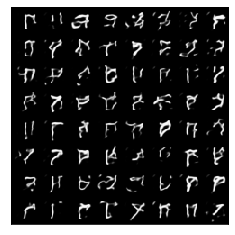

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 4e-05
Train G
tensor(1.7142e-15, device='cuda:0', grad_fn=<AddBackward0>)


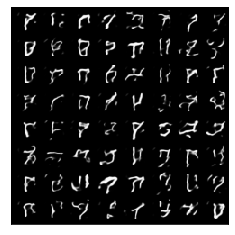

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.8120e-07, device='cuda:0', grad_fn=<AddBackward0>)


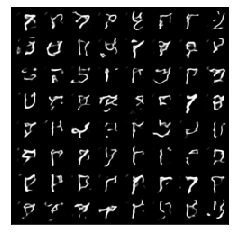

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.9599e-18, device='cuda:0', grad_fn=<AddBackward0>)


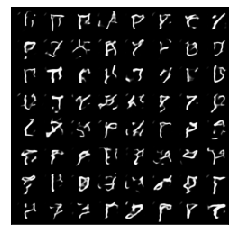

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 4e-05
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(8.9974e-05, device='cuda:0', grad_fn=<AddBackward0>)


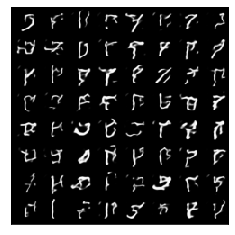

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.8434e-12, device='cuda:0', grad_fn=<AddBackward0>)


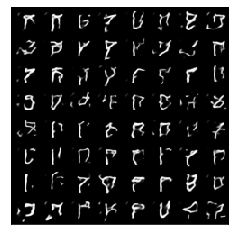

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.1349e-14, device='cuda:0', grad_fn=<AddBackward0>)


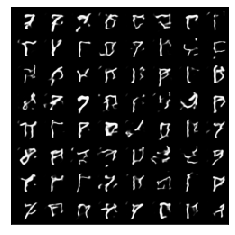

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(966.1512, device='cuda:0', grad_fn=<AddBackward0>)


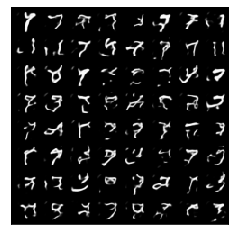

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.0943e-09, device='cuda:0', grad_fn=<AddBackward0>)


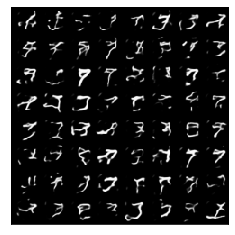

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.0047e-05, device='cuda:0', grad_fn=<AddBackward0>)


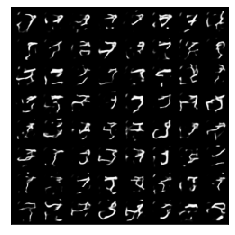

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)


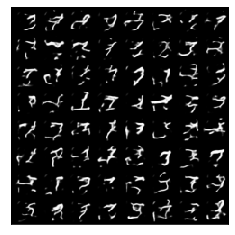

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.8983e-24, device='cuda:0', grad_fn=<AddBackward0>)


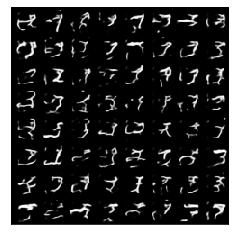

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(7.5329e-35, device='cuda:0', grad_fn=<AddBackward0>)


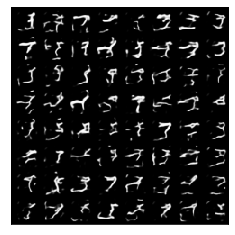

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.8929e-34, device='cuda:0', grad_fn=<AddBackward0>)


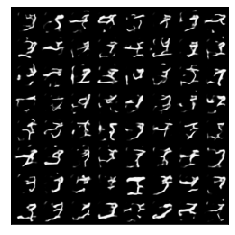

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0., device='cuda:0', grad_fn=<AddBackward0>)


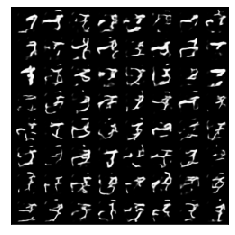

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.1822e-30, device='cuda:0', grad_fn=<AddBackward0>)


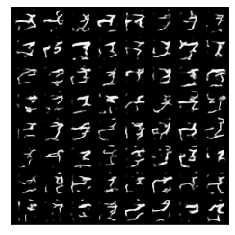

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(0.5454, device='cuda:0', grad_fn=<AddBackward0>)


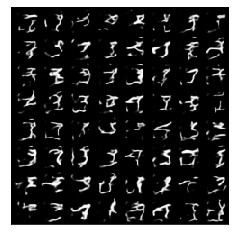

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 2e-05
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.7193e-11, device='cuda:0', grad_fn=<AddBackward0>)


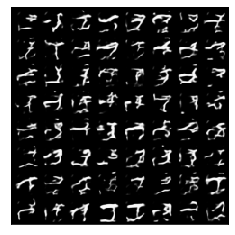

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(9.5756e-09, device='cuda:0', grad_fn=<AddBackward0>)


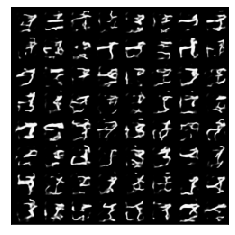

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.5237e-09, device='cuda:0', grad_fn=<AddBackward0>)


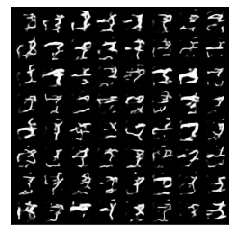

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.5155e-15, device='cuda:0', grad_fn=<AddBackward0>)


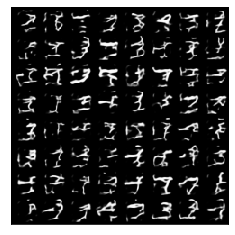

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(3.9466e-30, device='cuda:0', grad_fn=<AddBackward0>)


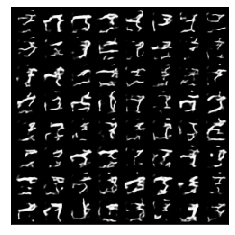

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.6994e-05, device='cuda:0', grad_fn=<AddBackward0>)


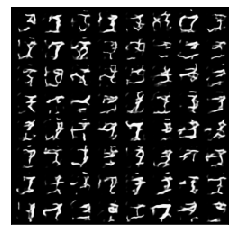

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(7.6182e-23, device='cuda:0', grad_fn=<AddBackward0>)


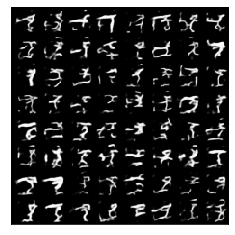

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.7213e-20, device='cuda:0', grad_fn=<AddBackward0>)


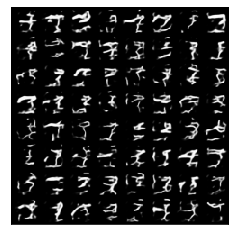

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.6970e-29, device='cuda:0', grad_fn=<AddBackward0>)


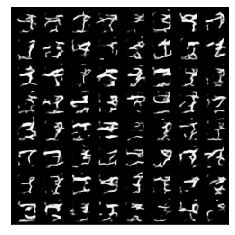

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(9.8973e-21, device='cuda:0', grad_fn=<AddBackward0>)


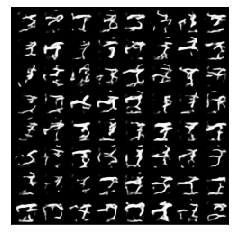

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.4746e-30, device='cuda:0', grad_fn=<AddBackward0>)


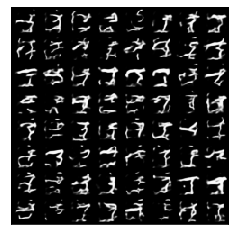

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(6.3843e-33, device='cuda:0', grad_fn=<AddBackward0>)


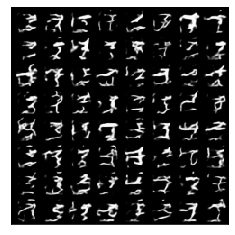

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(2.0120e-19, device='cuda:0', grad_fn=<AddBackward0>)


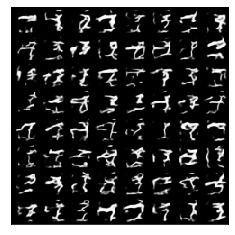

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0
Train G
tensor(1.4276e-12, device='cuda:0', grad_fn=<AddBackward0>)


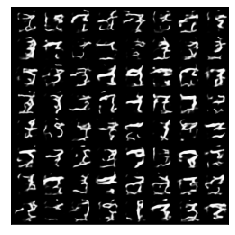

Train D
MLE Dis train: Epoch 0 Iter 0 Loss = 0.0
MLE Dis train: Epoch 0 Iter 150 Loss = 0.0
MLE Dis train: Epoch 0 Iter 300 Loss = 0.0
MLE Dis train: Epoch 0 Iter 450 Loss = 0.0


In [9]:
for _ in range(100):
    
    print('Train G')

    D.eval()
    G.eval()
    G_rollout.eval()

    n_samples = 32
    n_rollouts = 4
    n_rollout_samples = n_samples * n_rollouts
    device = CONFIG.DEVICE

    noise = torch.randn(1, n_samples, CONFIG.vocab_size, device=CONFIG.DEVICE)

    seq = G.sample(
        n_samples=n_samples,
        noise=noise,
        device=CONFIG.DEVICE,
        return_start_token=True)
    
    G.train()

    loss = 0
    for start_index in range(49):
        loss += one_step_pg_loss(
            seq=seq, 
            noise=noise, 
            G=G, 
            G_rollout=G_rollout, 
            D=D, 
            dvae=dvae, 
            start_index=start_index, 
            n_rollouts=n_rollouts, 
            hidden_height=CONFIG.hidden_height, 
            hidden_width=CONFIG.hidden_width, 
            device=CONFIG.DEVICE)
    
    print(loss)
    
    loss.backward()
    optimizer_G.step()
    optimizer_G.zero_grad()

    G_rollout.load_state_dict(G.state_dict())
    
    show_example(G, dvae, CONFIG)
    
    print('Train D')
    
    D = train_discriminator(
        discriminator=D,
        generator=G,
        optimizer_d=optimizer_D,
        train_loader=train_loader,
        dvae=dvae,
        hidden_height=CONFIG.hidden_height,
        hidden_width=CONFIG.hidden_width,
        num_epochs=1,
        device=CONFIG.DEVICE,
        verbose=True,
        print_iter=150)
